In [1]:
import os
import pickle
import matplotlib
import numpy as np
import typing as t
import seaborn as sns
import matplotlib.pyplot as plt

from v1t.utils import utils, tensorboard

utils.set_random_seed(1)

tensorboard.set_font()
IMAGE_SIZE = (1, 36, 64)
TICK_FONTSIZE, LABEL_FONTSIZE, TITLE_FONTSIZE = 7, 8, 9

In [2]:
def load_results(filename: str):
    with open(filename, "rb") as file:
        results = pickle.load(file)
    return results


cnn_results = load_results("../runs/sensorium/023_stacked2d_gaussian2d_bm0/aRFs.pkl")
vit_results = load_results("../runs/sensorium/026_vit_gaussian2d_bm0/aRFs.pkl")

### Plot aRF and 2D Gaussian fit of 6 random artificial units

In [3]:
random_units = np.random.choice(cnn_results["aRFs"].shape[0], size=6, replace=False)

In [4]:
normalize = lambda a: (a - a.min()) / (a.max() - a.min())


def Gaussian2d(
    xy: np.ndarray,
    amplitude: float,
    xo: float,
    yo: float,
    sigma_x: float,
    sigma_y: float,
    theta: float,
    offset: float,
):

    x, y = xy
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta) ** 2) / (2 * sigma_x**2) + (np.sin(theta) ** 2) / (
        2 * sigma_y**2
    )
    b = -(np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (
        4 * sigma_y**2
    )
    c = (np.sin(theta) ** 2) / (2 * sigma_x**2) + (np.cos(theta) ** 2) / (
        2 * sigma_y**2
    )
    g = offset + amplitude * np.exp(
        -(a * ((x - xo) ** 2) + 2 * b * (x - xo) * (y - yo) + c * ((y - yo) ** 2))
    )
    return g.ravel()


def plot_aRF(axis, aRF: np.ndarray, parameter: np.ndarray, title: str = None):
    height, width = aRF.shape[1], aRF.shape[2]
    x, y = np.linspace(0, width - 1, width), np.linspace(0, height - 1, height)
    x, y = np.meshgrid(x, y)
    aRF = normalize(aRF)
    axis.imshow(aRF[0], cmap="gray", vmin=0, vmax=1)
    fitted = Gaussian2d((x, y), *parameter)
    fitted = fitted.reshape(height, width)
    if not np.any(np.isnan(parameter)):
        # plot contour of 1 standard deviation ellipse
        axis.contour(
            x,
            y,
            normalize(fitted),
            levels=[np.percentile(fitted, q=84)],
            alpha=0.8,
            linewidths=2,
            colors="orangered",
        )
    if title is not None:
        axis.set_xlabel(title, labelpad=1, fontsize=LABEL_FONTSIZE)
    axis.set_xticks([])
    axis.set_yticks([])
    tensorboard.remove_spines(axis=axis)


def plot_aRFs(
    aRFs: np.ndarray,
    parameters: np.ndarray = None,
    title: str = None,
    filename: str = None,
):
    nrows, ncols = 2, 3

    figure, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        gridspec_kw={"wspace": 0.02, "hspace": 0.2},
        figsize=(6, 2.6),
        dpi=240,
    )
    axes = axes.flatten()

    for i, unit in enumerate(random_units):
        plot_aRF(
            axis=axes[i],
            aRF=aRFs[unit],
            parameter=parameters[unit],
            title=f"Unit #{unit}",
        )

    if title is not None:
        pos = axes[0].get_position()
        figure.suptitle(title, fontsize=TITLE_FONTSIZE, y=pos.y1 + 0.07)

    if filename is not None:
        tensorboard.save_figure(figure, filename=filename, dpi=240, close=False)

    plt.show()
    plt.close(figure)

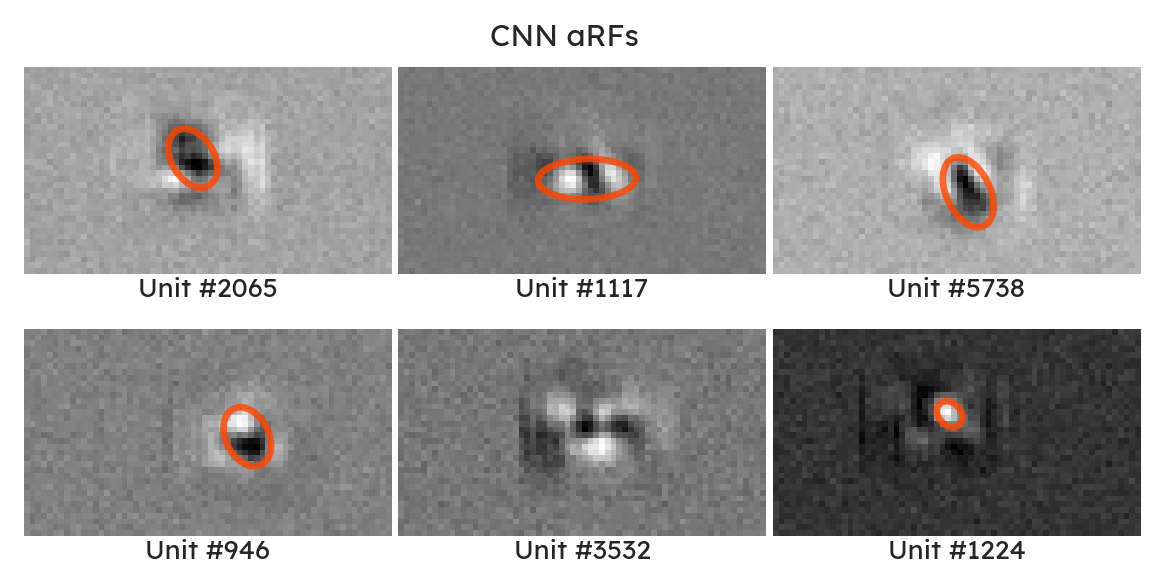

In [5]:
plot_aRFs(
    aRFs=cnn_results["aRFs"],
    parameters=cnn_results["popts"],
    title="CNN aRFs",
    filename="plots/CNN_aRFs.pdf",
)

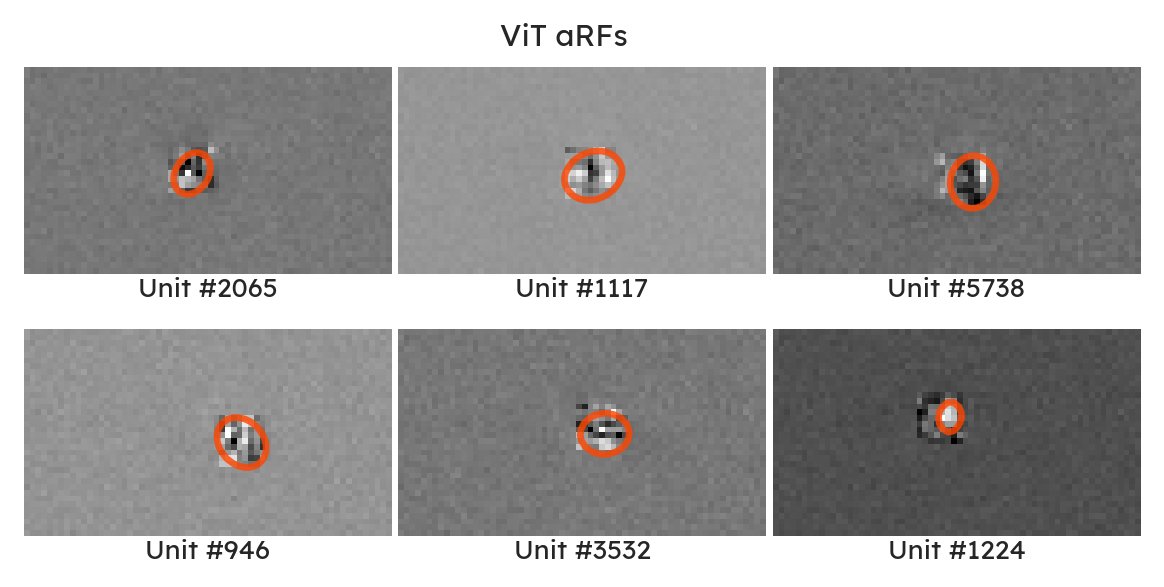

In [6]:
plot_aRFs(
    aRFs=vit_results["aRFs"],
    parameters=vit_results["popts"],
    title="ViT aRFs",
    filename="plots/ViT_aRFs.pdf",
)

### Plot CNN and ViT RF centers

In [7]:
def load_centers(popts: np.ndarray):
    x, y = popts[:, 1], popts[:, 2]
    x, y = x[~np.isnan(x)], y[~np.isnan(y)]
    x = x[np.where(x < IMAGE_SIZE[2])]
    y = y[np.where(y < IMAGE_SIZE[1])]
    return x, y

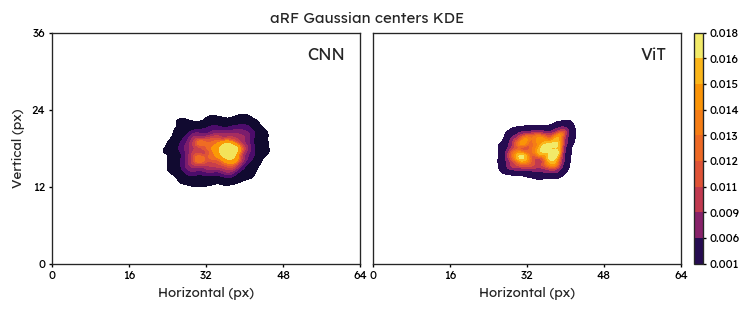

In [8]:
cnn_x, cnn_y = load_centers(cnn_results["popts"])
vit_x, vit_y = load_centers(vit_results["popts"])


figure, axes = plt.subplots(
    nrows=1,
    ncols=3,
    gridspec_kw={"wspace": 0.06, "hspace": 0.0, "width_ratios": [1, 1, 0.03]},
    figsize=(7, 2.5),
    dpi=120,
)

thresh, levels = 0.01, 10
kde_kw = {
    "fill": True,
    "levels": np.linspace(thresh, 1.0, levels),
    "thresh": thresh,
    "cmap": "inferno",
}
sns.kdeplot(
    x=cnn_x,
    y=cnn_y,
    ax=axes[0],
    **kde_kw,
    label="CNN",
)
sns.kdeplot(
    x=vit_x,
    y=vit_y,
    ax=axes[1],
    **kde_kw,
    label="ViT",
    cbar=True,
    cbar_ax=axes[2],
)
axes[0].legend(frameon=False)
axes[1].legend(frameon=False)
# axes[0].set_title("CNN", fontsize=TITLE_FONTSIZE, y=0.975)
# axes[1].set_title("ViT", fontsize=TITLE_FONTSIZE, y=0.975)

x_range = np.linspace(0, IMAGE_SIZE[2], 5)
y_range = np.linspace(0, IMAGE_SIZE[1], 4)

tensorboard.set_xticks(
    axis=axes[0],
    ticks_loc=x_range,
    ticks=x_range.astype(int),
    label="Horizontal (px)",
    tick_fontsize=TICK_FONTSIZE,
    label_fontsize=LABEL_FONTSIZE,
)
tensorboard.set_yticks(
    axis=axes[0],
    ticks_loc=y_range,
    ticks=y_range.astype(int),
    label="Vertical (px)",
    tick_fontsize=TICK_FONTSIZE,
    label_fontsize=LABEL_FONTSIZE,
)

tensorboard.set_xticks(
    axis=axes[1],
    ticks_loc=x_range,
    ticks=x_range.astype(int),
    label="Horizontal (px)",
    tick_fontsize=TICK_FONTSIZE,
    label_fontsize=LABEL_FONTSIZE,
)
axes[1].set_yticks([])
axes[1].set_ylim(0, IMAGE_SIZE[1])

ticks_loc = axes[2].get_yticks()
tensorboard.set_yticks(
    axis=axes[2],
    ticks_loc=ticks_loc,
    ticks=[f"{tick:.03f}" for tick in ticks_loc],
    tick_fontsize=TICK_FONTSIZE,
)

for ax in axes:
    tensorboard.set_ticks_params(axis=ax, length=2)

pos = axes[0].get_position()
figure.suptitle(
    "aRF Gaussian centers KDE",
    fontsize=TITLE_FONTSIZE,
    y=pos.y1 + 0.07,
)

filename = os.path.join("plots", "aRF_centers.png")
tensorboard.save_figure(figure, filename=filename, dpi=240, close=False)

plt.show()
plt.close(figure)

### Plot CNN and ViT Gaussian standard deviations

In [9]:
def load_sigmas(popts: np.ndarray):
    x, y = popts[:, 3], popts[:, 4]
    x, y = np.abs(x[~np.isnan(x)]), np.abs(y[~np.isnan(y)])
    return x, y

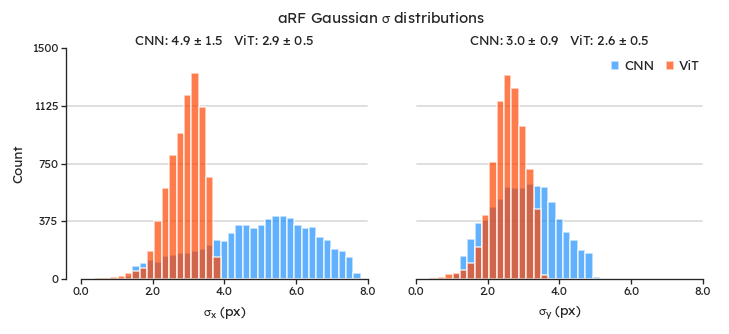

In [10]:
cnn_sigma_x, cnn_sigma_y = load_sigmas(cnn_results["popts"])
vit_sigma_x, vit_sigma_y = load_sigmas(vit_results["popts"])


figure, axes = plt.subplots(
    nrows=1,
    ncols=2,
    gridspec_kw={"wspace": 0.06, "hspace": 0.0},
    figsize=(7, 2.5),
    dpi=120,
)
alpha = 0.7
x_max = 8
y_max = 1500
bins = np.linspace(0, x_max, 40)

axes[0].hist(cnn_sigma_x, bins=bins, alpha=alpha, color="dodgerblue", label="CNN")
axes[0].hist(vit_sigma_x, bins=bins, alpha=alpha, color="orangered", label="ViT")

axes[1].hist(cnn_sigma_y, bins=bins, alpha=alpha, color="dodgerblue", label="CNN")
axes[1].hist(vit_sigma_y, bins=bins, alpha=alpha, color="orangered", label="ViT")

x_range = np.linspace(0, x_max, 5)
y_range = np.linspace(0, y_max, 5)

tensorboard.set_xticks(
    axis=axes[0],
    ticks_loc=x_range,
    ticks=x_range.round(2),
    label=r"$\sigma_x$ (px)",
    tick_fontsize=TICK_FONTSIZE,
    label_fontsize=LABEL_FONTSIZE,
)
tensorboard.set_yticks(
    axis=axes[0],
    ticks_loc=y_range,
    ticks=y_range.astype(int),
    label="Count",
    tick_fontsize=TICK_FONTSIZE,
    label_fontsize=LABEL_FONTSIZE,
)

tensorboard.set_xticks(
    axis=axes[1],
    ticks_loc=x_range,
    ticks=x_range.round(2),
    label=r"$\sigma_y$ (px)",
    tick_fontsize=TICK_FONTSIZE,
    label_fontsize=LABEL_FONTSIZE,
)
axes[1].set_yticks([])
axes[1].set_ylim(0, y_max)

sns.despine(ax=axes[0], top=True, right=True, trim=True)
sns.despine(ax=axes[1], top=True, right=True, left=True, trim=True)

# plot y-axis grid lines
for y_value in y_range:
    if 0 < y_value < y_max:
        axes[0].axhline(
            y_value, xmax=0.95, color="gray", alpha=0.3, linewidth=1, zorder=0
        )
        axes[1].axhline(
            y_value,
            xmin=0.05,
            xmax=0.95,
            color="gray",
            alpha=0.3,
            linewidth=1,
            zorder=0,
        )


title1 = rf"CNN: {np.mean(cnn_sigma_x):.01f} $\pm$ {np.std(cnn_sigma_x):.01f}   "
title1 += rf"ViT: {np.mean(vit_sigma_x):.01f} $\pm$ {np.std(vit_sigma_x):.01f}"
axes[0].set_title(title1, fontsize=LABEL_FONTSIZE, pad=0)


title2 = rf"CNN: {np.mean(cnn_sigma_y):.01f} $\pm$ {np.std(cnn_sigma_y):.01f}   "
title2 += rf"ViT: {np.mean(vit_sigma_y):.01f} $\pm$ {np.std(vit_sigma_y):.01f}"
axes[1].set_title(title2, fontsize=LABEL_FONTSIZE, pad=0)

axes[1].legend(
    loc="upper right",
    bbox_to_anchor=(0.98, 1.0),
    ncols=2,
    frameon=False,
    handletextpad=0.35,
    handlelength=0.6,
    markerscale=0.8,
    columnspacing=0.85,
    fontsize=LABEL_FONTSIZE,
)

pos = axes[0].get_position()
figure.suptitle(
    r"aRF Gaussian $\sigma$ distributions",
    fontsize=TITLE_FONTSIZE,
    y=pos.y1 + 0.12,
)

tensorboard.save_figure(
    figure, filename=os.path.join("plots", "aRF_sigmas.png"), dpi=240, close=False
)

plt.show()
plt.close(figure)

### Single plot

In [11]:
def plot_aRFs(
    figure: matplotlib.figure.SubFigure,
    units: t.List[int],
    aRFs: np.ndarray,
    parameters: np.ndarray = None,
    title: str = None,
    x0: float = 0,
    y0: float = 0,
):
    width, height, wspace = 0.2, 0.15, 0.005

    ax1 = figure.add_axes(rect=[x0, y0, width, height])
    plot_aRF(
        axis=ax1,
        aRF=aRFs[units[0]],
        parameter=parameters[units[0]],
        title=f"Unit #{units[0]}",
    )
    pos1 = ax1.get_position()

    ax2 = figure.add_axes(rect=[pos1.x1 + wspace, pos1.y0, width, height])
    plot_aRF(
        axis=ax2,
        aRF=aRFs[units[1]],
        parameter=parameters[units[1]],
        title=f"Unit #{units[1]}",
    )
    pos2 = ax2.get_position()

    ax3 = figure.add_axes(rect=[pos2.x1 + wspace, pos1.y0, width, height])
    plot_aRF(
        axis=ax3,
        aRF=aRFs[units[2]],
        parameter=parameters[units[2]],
        title=f"Unit #{units[2]}",
    )
    pos3 = ax3.get_position()

    if title is not None:
        ax2.set_title(title, fontsize=LABEL_FONTSIZE, pad=0)
    return [pos1, pos2, pos3]


def plot_centers(
    figure: matplotlib.figure.SubFigure,
    cnn_parameters: np.ndarray,
    vit_parameters: np.ndarray,
    x0: float,
    y0: float,
):
    cnn_x, cnn_y = load_centers(cnn_parameters)
    vit_x, vit_y = load_centers(vit_parameters)
    width, height, wspace = 0.3, 0.19, -0.005

    ax1 = figure.add_axes(rect=[x0, y0, width, height])

    thresh, levels = 0.01, 10
    kde_kw = {
        "fill": True,
        "levels": np.linspace(thresh, 1.0, levels),
        "thresh": thresh,
        "cmap": "inferno",
    }
    sns.kdeplot(
        x=cnn_x,
        y=cnn_y,
        ax=ax1,
        **kde_kw,
        label="CNN",
    )
    ax1.set_aspect("equal")
    pos1 = ax1.get_position()

    ax2 = figure.add_axes(rect=[pos1.x1 + wspace, pos1.y0, width, height])
    ax3 = figure.add_axes(rect=[pos1.x1 + width - 0.03, pos1.y0, 0.008, height])
    sns.kdeplot(
        x=vit_x,
        y=vit_y,
        ax=ax2,
        **kde_kw,
        label="ViT",
        cbar=True,
        cbar_ax=ax3,
    )
    ax2.set_aspect("equal")

    x_range = np.linspace(0, IMAGE_SIZE[2], 5)
    y_range = np.linspace(0, IMAGE_SIZE[1], 4)

    tensorboard.set_xticks(
        axis=ax1,
        ticks_loc=x_range,
        ticks=x_range.astype(int),
        tick_fontsize=TICK_FONTSIZE,
    )
    ax1.set_xlabel("Horizontal (px)", fontsize=TICK_FONTSIZE, labelpad=0)
    tensorboard.set_yticks(
        axis=ax1,
        ticks_loc=y_range,
        ticks=y_range.astype(int),
        tick_fontsize=TICK_FONTSIZE,
    )
    ax1.set_ylabel("Vertical (px)", fontsize=TICK_FONTSIZE, labelpad=0)

    tensorboard.set_xticks(
        axis=ax2,
        ticks_loc=x_range,
        ticks=x_range.astype(int),
        tick_fontsize=TICK_FONTSIZE,
    )
    ax2.set_xlabel("Horizontal (px)", fontsize=TICK_FONTSIZE, labelpad=0)
    ax2.set_yticks([])
    ax2.set_ylim(0, IMAGE_SIZE[1])

    ticks_loc = ax3.get_yticks()
    tensorboard.set_yticks(
        axis=ax3,
        ticks_loc=ticks_loc,
        ticks=[f"{tick:.03f}" for tick in ticks_loc],
        tick_fontsize=TICK_FONTSIZE,
    )
    pos2 = ax2.get_position()
    pos3 = ax3.get_position()
    for ax in [ax1, ax2, ax3]:
        tensorboard.set_ticks_params(axis=ax, length=1.5, pad=1)

    return [pos1, pos2, pos3]

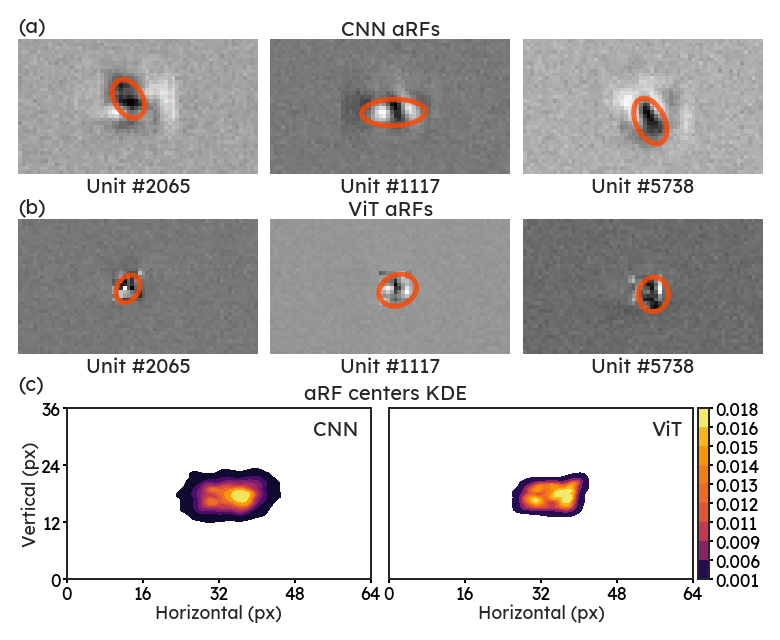

In [12]:
figure = plt.figure(figsize=(7, 5), dpi=180)


top_pos = plot_aRFs(
    figure=figure,
    units=random_units[:3],
    aRFs=cnn_results["aRFs"],
    parameters=cnn_results["popts"],
    title="CNN aRFs",
    x0=0.0,
    y0=0.0,
)
mid_pos = plot_aRFs(
    figure=figure,
    units=random_units[:3],
    aRFs=vit_results["aRFs"],
    parameters=vit_results["popts"],
    title="ViT aRFs",
    x0=0,
    y0=-0.2,
)
bottom_pos = plot_centers(
    figure=figure,
    cnn_parameters=cnn_results["popts"],
    vit_parameters=vit_results["popts"],
    x0=0.014,
    y0=-0.45,
)

pad = 0.02
figure.text(
    x=top_pos[0].x0,
    y=top_pos[0].y1 + 0.008,
    s="(a)",
    fontsize=LABEL_FONTSIZE,
    ha="left",
)
figure.text(
    x=mid_pos[0].x0,
    y=mid_pos[0].y1 + 0.008,
    s="(b)",
    fontsize=LABEL_FONTSIZE,
    ha="left",
)
figure.text(
    x=mid_pos[0].x0,
    y=bottom_pos[0].y1 + pad,
    s="(c)",
    fontsize=LABEL_FONTSIZE,
    ha="left",
)
figure.text(
    x=(bottom_pos[0].x0 + bottom_pos[1].x1) / 2,
    y=bottom_pos[0].y1 + 0.01,
    s="aRF centers KDE",
    fontsize=LABEL_FONTSIZE,
    ha="center",
)
figure.text(
    x=bottom_pos[0].x1 - 0.0,
    y=bottom_pos[0].y1 - 0.03,
    s="CNN",
    fontsize=LABEL_FONTSIZE,
    ha="right",
)
figure.text(
    x=bottom_pos[1].x1 - 0.008,
    y=bottom_pos[1].y1 - 0.03,
    s="ViT",
    fontsize=LABEL_FONTSIZE,
    ha="right",
)

tensorboard.save_figure(figure, filename="plots/aRFs.pdf", dpi=240, close=False)

plt.show()
plt.close(figure)

### Compute aRFs in degree

In [13]:
DISTANCE = 15  # distance to monitor in cm
MONITOR_DIMENSION = (31.8, 56.5)  # (height, width) in cm

cnn_sigma_x, cnn_sigma_y = load_sigmas(cnn_results["popts"])
vit_sigma_x, vit_sigma_y = load_sigmas(vit_results["popts"])


def compute_degree(sigma: np.ndarray, axis: t.Literal["x", "y"] = "x"):
    radius_px = np.mean(sigma)  # in px
    # convert px to cm
    radius_cm = radius_px * (
        MONITOR_DIMENSION[1 if axis == "x" else 0] / IMAGE_SIZE[2 if axis == "x" else 1]
    )
    degree = np.degrees(np.arctan(radius_cm / DISTANCE))
    return degree


print(f"CNN x-axis degree: {compute_degree(cnn_sigma_x):.03f}")
print(f"ViT x-axis degree: {compute_degree(vit_sigma_x):.03f}\n")
print(f"CNN y-axis degree: {compute_degree(cnn_sigma_y, axis='y'):.03f}")
print(f"ViT y-axis degree: {compute_degree(vit_sigma_y, axis='y'):.03f}")

CNN x-axis degree: 16.108
ViT x-axis degree: 9.740

CNN y-axis degree: 10.088
ViT y-axis degree: 8.678
